In [1]:
import os
import json
from json import JSONDecodeError
import sys
import elasticsearch
import warnings
warnings.filterwarnings("ignore", message="ElasticsearchWarning")
sys.path.insert(0, '/home/guinzburg/NLP/Data')
from data_parser import parse_queries, parse_documents, parse_data_ground_truth

## ElasticSearch
Full-text search queries and performs linguistic searches against documents. It includes single or multiple words or phrases and returns documents that match search condition.

ElasticSearch is a search engine based on Apache Lucene, a free and open-source information retrieval software library. It provides a distributed, full-text search engine with an HTTP web interface and schema-free JSON documents.

Documents are represented as JSON objects. JSON serialization is supported by most programming languages and has become the standard format used by the NoSQL movement. It is simple, concise, and easy to read.

https://www.baeldung.com/elasticsearch-full-text-search-rest-api

## Documents, Queries, and Ground Truth
Load the files containing queries, documents and ground truth using 'parse_queries', 'parse_documents', and parse_data_ground_truth, then create json objects for each one
for further processing

In [2]:
# Get all queries
queries = json.loads(json.dumps(parse_queries(path='/home/guinzburg/NLP/Data/CISI.QRY'), indent = 4))
# Get all documents
documents = json.loads(json.dumps(parse_documents(path='/home/guinzburg/NLP/Data/CISI.ALL'), indent = 4))
# Get ground truth
ground_truth = json.loads(json.dumps(parse_data_ground_truth(path='/home/guinzburg/NLP/Data/CISI.REL'), indent = 4))

## Validate ElasticSearch service is up and running
By instantiate a client instance and using an API callcall' in this example `info()` we can validate that the service is running properly <br><br>
<i>Plain vanilla curl command: curl -XGET 'http://localhost:9200/</i>

In [4]:
try:
    es = elasticsearch.Elasticsearch("http://localhost:9200")
    print("ElasticSearch service is up and running.","\nVersion:", es.info()['version']['number'])
except elasticsearch.ElasticsearchException as e:
    print("ElasticSearch service is not running.\n")

ElasticSearch service is up and running. 
Version: 7.15.0


## Updating ElasticSearch with Documents
ElasticSearch is document oriented. It stores and indexes documents. Indexing creates or updates documents. After indexing, you can search, sort, and filter complete documents. Using ElasticSearch.index<br><br>
<i>Plain vanilla curl command: 
curl -XPUT 'localhost:9200/text/article/1?pretty'
-H 'Content-Type: application/json' -d '
{
  "title": "He went",
  "random_text": 
    "He went such dare good fact. The small own seven saved man age."
}</i>

In [5]:
for id in documents:
    
    # Create document 
    document = {
        "title": documents[id]['title'],
        "text": documents[id]['body']
    }

    # Use ElasticSearch client to insert a document
    res = es.index(index="document", id=id, document=document)
    
    # Verify update was sucessful
    try:
        _ = res['result']

    except elasticsearch.ElasticsearchException as e:
        print("Update error", "Document ID:", id, "Actual Error:", e)

## Count ElasticSearch Documents
Get the number of documents within ElasticSearch using ElasticSearch.count<br><br>
<i>plain vanilla curl command:"curl -XGET 'localhost:9200/document/_count?pretty'</i>

In [6]:
es_doc_count = es.count(index="document", body = dict())['count']

print(f"{es_doc_count} / {len(documents)} documents were UPDATED")

1460 / 1460 documents were UPDATED


## Search ElasticSearch for Documents
Get all documents hits that match'es the query defined in the request using ElasticSearch.search<br><br>
<i>plain vanilla curl command: 
curl -XGET 'localhost:9200/text/article/_search?pretty' 
-H 'Content-Type: application/json' -d '
{
  "query": {
    "match": {
      "random_text": "him departure"
    }
  }
}'</i>

In [7]:
# create a Python dictionary for the search query:

queries_response = {}

for q_id in queries:

    # Prepare query 
    search_param = {
          # "size" : defule_value_is_10,
          "query": {
              "simple_query_string" : {
                  "query": queries[q_id] 
                    }
            }
    }
    
    # Get a response from the cluster
    response = es.search(index="document", body=search_param)
    
    # Save all results (documents ID's) for each query
    queries_response[q_id] = []
    for item in response['hits']['hits']:
        queries_response[q_id].append((item['_id'], item['_score']))

<ipython-input-7-756190fd565c>:18: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in 8.0.0. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  response = es.search(index="document", body=search_param)


## Precision and Recall
#### Precision
Precision measures "of all the documents we retrieved as relevant how many are actually relevant?"
Precision = No. of relevant documents retrieved / No. of total documents retrieved<br><br>
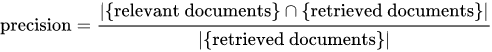
#### Recall
Recall is the fraction of the documents that are relevant to the query that are successfully retrieved
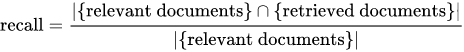


In [8]:
# Calcualte precision and recall for each query using ground truth
def common(a, b): 
    c = [value for value in a if value in b] 
    return c

queries_precision_recall = {}
for q_id in queries_response:
    if q_id not in queries_precision_recall.keys():
        queries_precision_recall[q_id] = []
    try:
        c = common(ground_truth[q_id], [item[0] for item in queries_response[q_id]])
        queries_precision_recall[q_id].append(len(c)/len(queries_response[q_id]))
        queries_precision_recall[q_id].append(len(c)/len(ground_truth[q_id]))
    except KeyError:
        queries_precision_recall[q_id].append(0)
        queries_precision_recall[q_id].append(0)
        pass

In [9]:
print("Query ID 50:", queries["50"])
print("Relevant Documents:", ground_truth["50"])
print("Retrived Documents:",  [item[0] for item in queries_response[q_id]])
print("Precision:", queries_precision_recall["50"][0])
print("Recall:", queries_precision_recall["50"][1])

Query ID 50: Is there any use for traditional classification schemes - DDC, UDC, LC, etc. - in information retrieval systems? If there is, which scheme appears most suited to machine use and where has it been applied? If there is not, why are these classification schemes irrelevant? Has research shown that a subject classification of knowledge is completely unnecessary in machine systems? Or, have new schemes been devised which appear to be more suited to machine use?
Relevant Documents: ['1', '16', '45', '80', '154', '209', '257', '258', '259', '260', '262', '263', '275', '276', '333', '334', '335', '342', '354', '361', '388', '404', '480', '488', '522', '527', '530', '564', '576', '596', '608', '701', '702', '758', '769', '797', '801', '817', '820', '825', '830', '838', '853', '868', '869', '884', '898', '931', '960', '966', '989', '993', '996', '999', '1010', '1066', '1072', '1074', '1075', '1103', '1137', '1140', '1141', '1170', '1202', '1215', '1216', '1230', '1231', '1259', '1265

In [10]:
# Calcualte average Precision and Recall
sum_precision = sum_recall = 0
for q_id in queries_precision_recall:
    sum_precision += queries_precision_recall[q_id][0]
    sum_recall += queries_precision_recall[q_id][1]
print("Average Precision:", sum_precision/112)
print("Average Precision:", sum_recall/112)

Average Precision: 0.19821428571428568
Average Precision: 0.06999870535046977
